In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dateutil.parser import parse
import seaborn as sns
import datetime
import statsmodels as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.gridspec import GridSpec
sns.set()

In [2]:
def box_cox(y, lam):
    """
    This computes the Box-Cox transformation given the data y and parameter lam
    inputs:
    ------
            y: time series
            lam: parameter
    output:
            A array of transformed time series
    """
    if lam == 0:
        return np.log(y)
    else:
        return ((y**lam) -  1)/lam

def reverse_box_cox(w,lam):
    """
    This computes the reverse Box-Cox transformation given the data w and parameter lam
    inputs:
    ------
            w: transformed time series
            lam: parameter
    output:
            A array of transformed time series
    """
    if lam == 0:
        return np.exp(w)
    else:
        return (lam*w + 1)**(1/lam)
    
def reverse_box_cox_adjusted(w,s,lam):
    """
    This computes the bias adjusted reverse Box-Cox transformation given the data w and parameters lam 
    and  s
    inputs:
    ------
            w: transformed time series
            s: h-step forecast variance
            lam: parameter
    output:
            A array of transformed time series
    """
    if lam == 0:
        ss = s*s/2
        return np.exp(w)*(1 + ss)
    else:
        num = s*s*(1 - lam)
        denum = 2*((lam*w + 1)**2)
        fact = 1 + num/denum
        return ((lam*w + 1)**(1/lam))*fact

In [3]:
# simple forecast methods for benchmark purposes

def mean_forecast(ts):
    """
    Compute forecast of time series using average value of past values
    input:
    ------
        val: values of time series
        
    output:
    ------- 
            average values
    """
    return np.mean(ts.values)


def naive_forecast(ts):
    """
    Compute forecast of time series using last observed value of past values
    input:
    ------
        val: values of time series
        
    output:
    ------- 
              Last observed value
    """
    return ts.tail(1).values[0]

def drift_forecast(ts, h = 1):
    """
    Computes a drifted naive version fo the method
    input:
    ----- 
        ts: a ts series. It has to be a pandas.Series object
        h: the number future step to estimate
        
    output:
        a number.
    """
    T = ts.shape[0]
    now_val = naive_forecast(ts)
    dfact = ( now_val - ts.head(1)[0])/(T-1)
    return now_val + h*dfact

def seasonal_naive(ts, m = 12):
    """
    Computes naive seasonal. This simply set each forecast to be equal to the last observed value 
    from the same season.
    inputs:
        ts -> pandas.Series object. This must be a time series. That is it's index must be timestamps
        m -> The seasonal period
    
    outputs:
            pandas.Series object for the next seasonal period
    """
    return ts[-m:].values

In [4]:
# model valuation utility functions
# Naive implementations

def mae(errts):
    """
    Computes mean absolute error
    
    input: errts: error time series. 
    
    output: a single value
    """
    return np.abs(errts).mean()

def rmse(errts):
    """
    Computes root mean square error
    
    input: errts: error time series. 
    
    output: a single value
    """
    return np.sqrt(np.mean(errts**2))
    
def mape(err,ts):
    """
    Computes mean absolute percentage error
    
    input: errts: error time series. 
    outpute: a single value
    """
    try:
        return np.mean(np.abs(err/ts))
    except ZeroDivisionError:
        print('check you time series values, some values are zero.')

In [5]:
# df = pd.read_csv('../data/tute1.csv')

# df = df.rename(columns= {'Unnamed: 0': 'Date'})

# # month = df['Unnamed: 0'].str.extract(r'([a-zA-Z]+)').squeeze().unique()
# def parseDate(d):
#     month_to_num = {
#      'Mar':'03',
#      'Jun':'06',
#      'Sep':'09',
#      'Dec':'12'
#     }
#     mon, year = d.split('-')
#     year = year.strip()
#     month = int(month_to_num[mon])
#     if int(year) >=50:
#         year = int('19'+year)
#         return datetime.datetime(year,month, 1)
#     else:
#         year = int('20'+year)
#         return datetime.datetime(year,month, 1)

# df['Date'] = df.Date.apply(parseDate)

# df = df.set_index('Date')

# _, ax  = plt.subplots(figsize = (15,8))
# df.plot(ax = ax)

# Exploring month Australian glossary retail data

In [6]:
df = pd.read_excel('../data/retail.xlsx',skiprows=[1], parse_date = True)
df = df.rename(columns= {'Unnamed: 0': 'Date'})
df = df.set_index('Date')

In [7]:
df.columns =[x.strip() for x in df.columns.str.split(';').str[-2]]

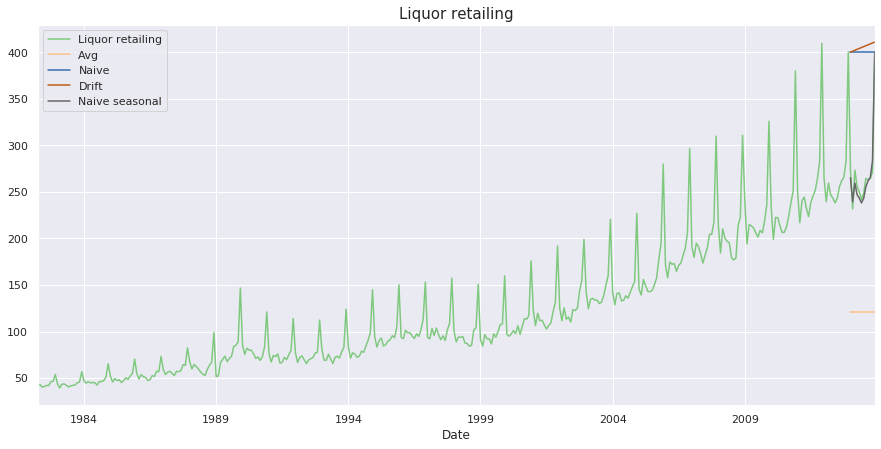

In [8]:
# plot time series
# plot of monthly forecast for year 2013
n = 1

dfn = df.iloc[:,n]
_, ax = plt.subplots(figsize = (15,7))
n = 1
# dfn.plot(ax= ax)

avg_fc = pd.Series(np.repeat(mean_forecast(dfn[:'2012']),12 ), index = dfn['2013'].index, name = 'Avg')
naive_fc = pd.Series(np.repeat(naive_forecast(dfn[:'2012']),12 ), index = dfn['2013'].index, name = 'Naive')
drift_fc = pd.Series([drift_forecast(dfn[:'2012'],i) for i in range(12)], index = dfn['2013'].index, name = 'Drift')
seas_naive_fc =  pd.Series(seasonal_naive(dfn[:'2012']), index = dfn['2013'].index, name = 'Naive seasonal')
t = pd.merge(dfn, avg_fc, left_index = True, right_index = True, how = 'left')
t = pd.merge(t, naive_fc, left_index = True, right_index = True, how = 'left')
t = pd.merge(t, drift_fc, left_index = True, right_index = True, how = 'left')
t = pd.merge(t, seas_naive_fc, left_index = True, right_index = True, how = 'left')
t.plot(ax = ax, colormap = matplotlib.cm.Accent)
plt.title(df.columns[n], fontsize = 15);


In [9]:
def avg_method(ts):
    val = ts.values
    n = ts.shape[0]
    data = np.repeat(np.nan,n)
    out = pd.Series(data, index = ts.index)
    out[0] = ts[0]
    for i in range(1,n):
        out[i] = np.mean(ts[:i+1])
    return out

def drift_method(ts, h= 1):
   
    T = ts.shape[0]
    data = np.repeat(np.nan,T)
    out = pd.Series(data, index = ts.index)
    out[0] = ts[0]
    for i in range(1,T):
        subseries = ts[:i+1]
        out[i] = drift_forecast(subseries, h)
    return out


In [10]:
def residual_plots(err, name = ''):
    """
    Function takes error time series and time series name.
    inputs:
            err: pandas.Series -> a time series
            name: string -> name of time series object
    outputs:
            (ax1, ax2, ax3)
    """
    fig = plt.figure(figsize = (15, 10))
    grid = GridSpec(2,2)
    ax1 = fig.add_subplot(grid[0,:])
    ax2 = fig.add_subplot(grid[1,0])
    ax3 = fig.add_subplot(grid[1,1])
    ax1.plot(err)
    ax2.hist(err)
    plot_acf(err, ax = ax3)
    fig.suptitle('Residual plot: '+ name, fontsize = 15)
    return (ax1, ax2, ax3)

In [11]:
# training error/residuals
naive_res = (dfn[:'2012']  - dfn[:'2012'].shift(1)).fillna(0)
avg_res = dfn[:'2012'] - avg_method(dfn[:'2012'])
seas_naive_res = (dfn['1983':'2012']  - dfn['1983':'2012'].shift(12)).fillna(0)
drift_res = dfn[:'2012'] - drift_method(dfn[:'2012'])

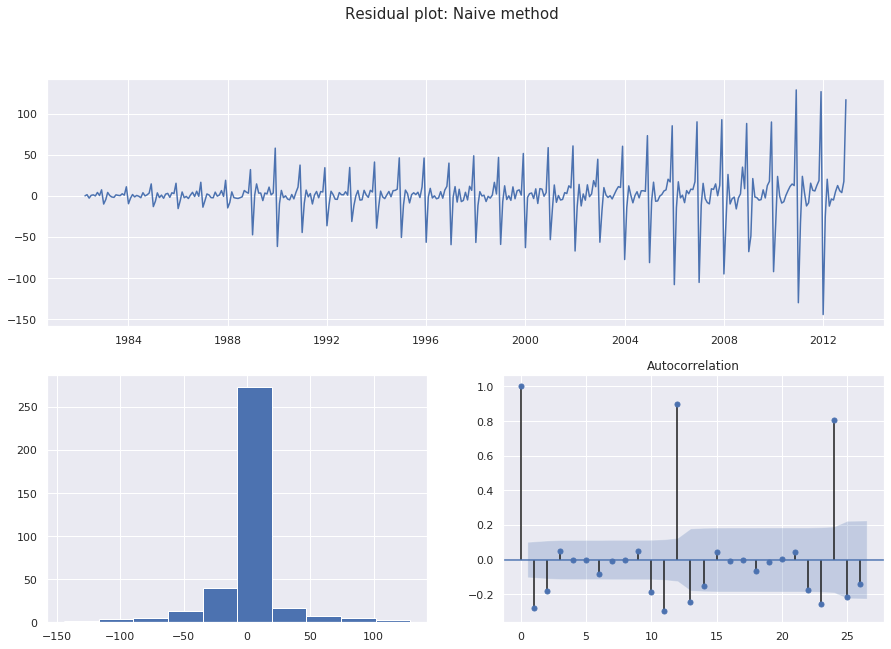

In [12]:
residual_plots(naive_res, 'Naive method');

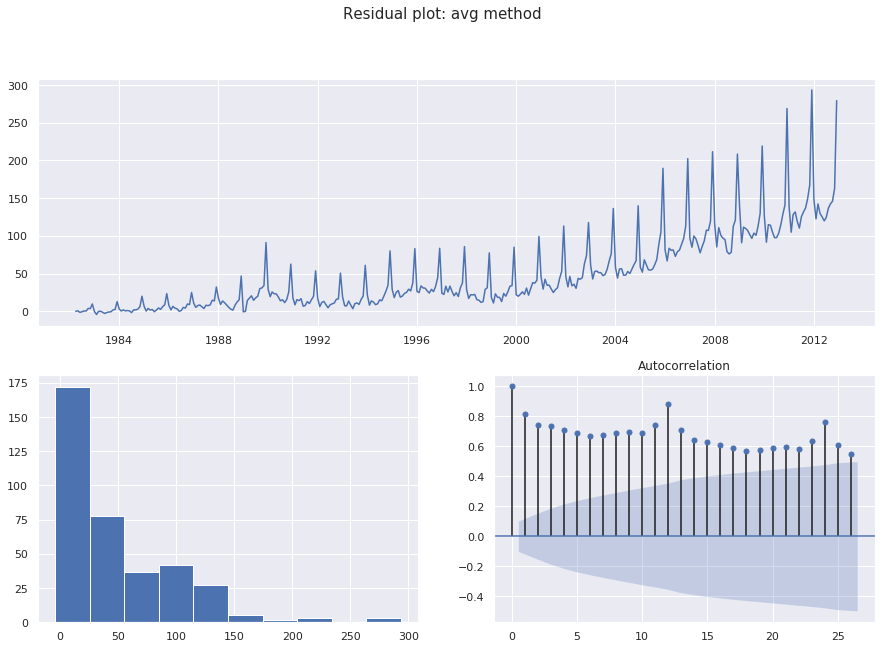

In [13]:
residual_plots(avg_res, 'avg method');

(<matplotlib.axes._subplots.AxesSubplot at 0x7f689391d850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68930ad610>)

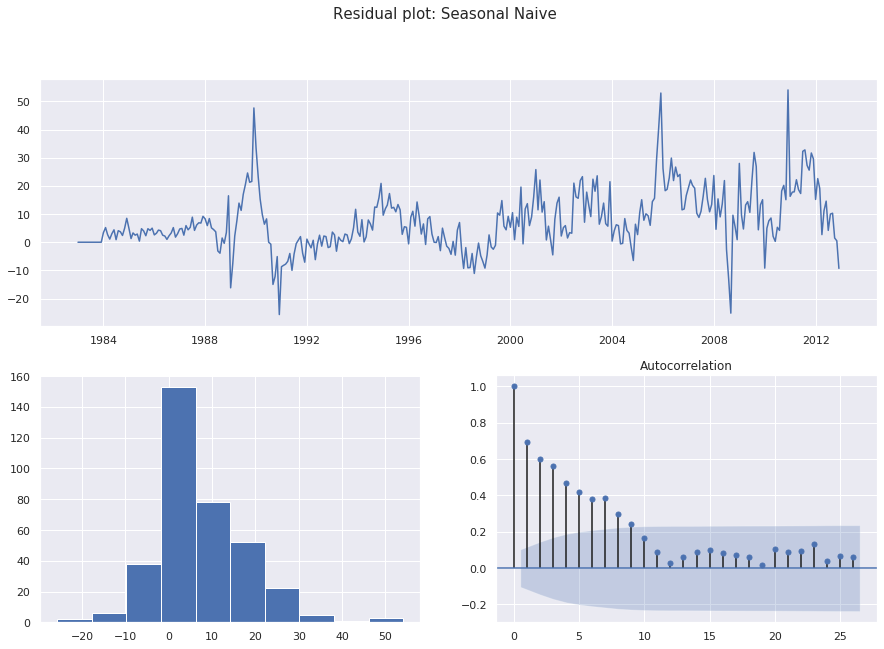

In [14]:
residual_plots(seas_naive_res,'Seasonal Naive')

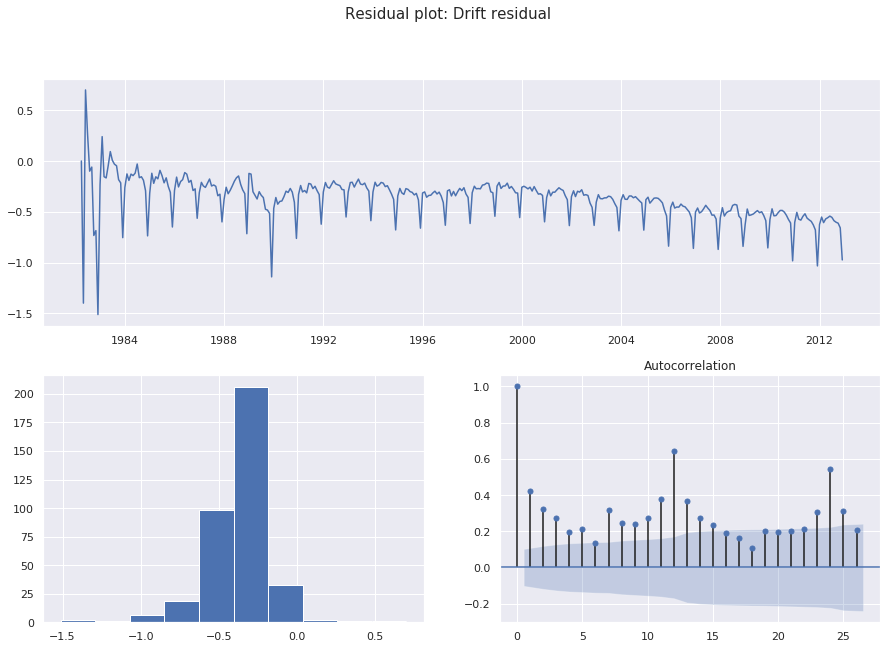

In [15]:
residual_plots(drift_res,'Drift residual');

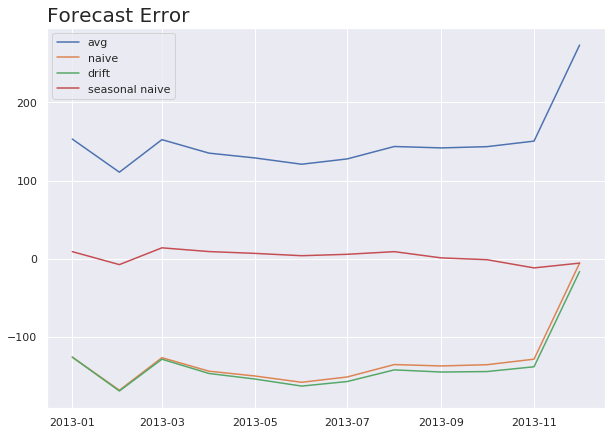

In [16]:
# Plot of forecast
methods = [avg_fc, naive_fc, drift_fc, seas_naive_fc]
labels = ['avg','naive','drift','seasonal naive']
_, ax = plt.subplots(figsize = (10,7))
for i, meth in enumerate(methods):
    res = dfn['2013'] - meth
    ax.plot(res, label = labels[i])
plt.legend()
plt.title('Forecast Error', loc = 'left' ,fontsize = 20);

In [17]:
# residuals
residuals = t['2013'].apply(lambda x: t['2013']['Liquor retailing'] - x).drop('Liquor retailing', axis = 1)
residuals.head(2)

,Avg,Naive,Drift,Naive seasonal
Date,,,,
2013-01-01,153.066938,-126.2,-126.200000,8.9
2013-02-01,110.666938,-168.6,-169.574457,-7.7


In [18]:
def report_residual_summary(res, ts):
    """
    Function computes model evaluation scores:
    1. Mean Absolute Error (MAE)
    2. Root Squared Mean Error  (RMSE)
    3. Mean Absolute Percentage Error (MAPE)
    for the given residual time series `res`
    
    inputs:
            res: pandas.Series object -> Residual time series
            ts: pandas.Series object -> Actual time series data
    output:
        DataFrame
    """
    MSE = res.apply(mae)
    MSE.name = 'mae'
    RMSE = res.apply(rmse)
    RMSE.name = 'rmse'
    MAPE = res.apply(mape,ts = ts )
    MAPE.name = 'mape'
    t = pd.merge(MSE,RMSE, left_index = True, right_index = True)
    return pd.merge(t,MAPE, left_index = True, right_index = True)

In [19]:
report_residual_summary(residuals, dfn['2013'])

,mae,rmse,mape
Avg,148.441938,153.667235,0.543442
Naive,130.825000,136.725238,0.510003
Drift,136.184511,141.413572,0.529476
Naive seasonal,7.016667,7.937254,0.026368


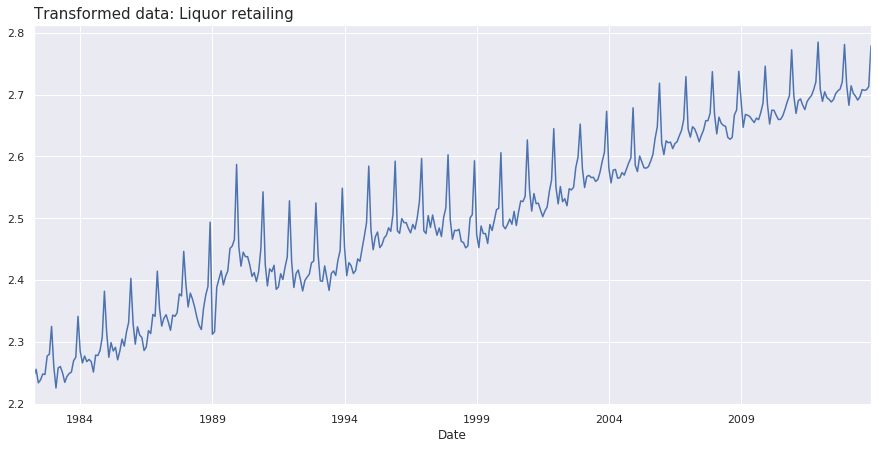

In [20]:
n = 1

dfn = df.iloc[:,n]
dfn = dfn.apply(box_cox,lam = -0.3) # transform data
title = df.columns[n]
_, ax = plt.subplots(figsize = (15,7))
dfn.plot(ax= ax)
plt.title('Transformed data: ' +title , fontsize = 15, loc = 'left');


In [21]:
# # Plot of forecast using transformed data
# methods = [avg_fc, naive_fc, drift_fc, seas_naive_fc]
# labels = ['avg','naive','drift','seasonal naive']
# _, ax = plt.subplots(figsize = (10,7))
# for i, meth in enumerate(methods):
#     res = dfn['2013'] - meth
#     ax.plot(res, label = labels[i])
# plt.legend()
# plt.title('Forecast Error', loc = 'left' ,fontsize = 20);

In [22]:
# Function to normalize datatime object to just year
def normalize(df):
    df.index = df.index.year
    return df

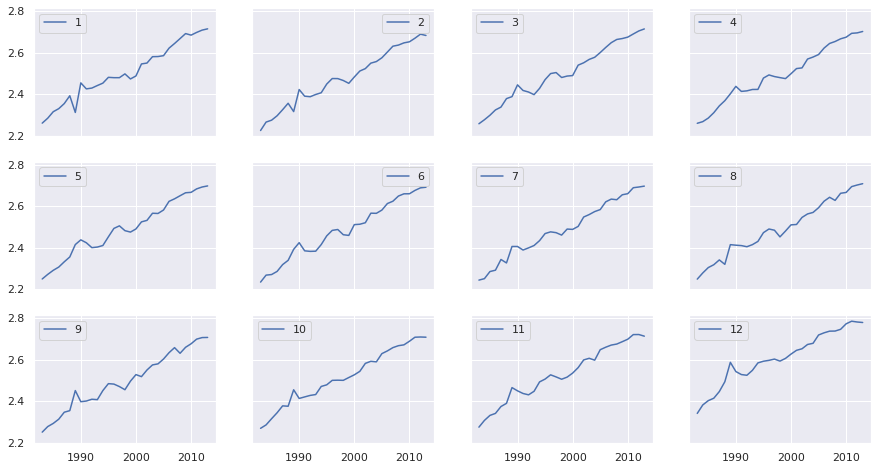

In [23]:
# group data by month
by_month = dict(list(dfn.groupby(dfn.index.month)))

# normalize datatime object to just year
by_month = {k:normalize(v) for k,v in by_month.items()}

# Create columns for each month
dff = pd.DataFrame([], index = by_month[1].index)
for k,g in by_month.items():
    g.name = k
    dff = pd.merge(dff,g, left_index = True, right_index = True)

# plot of monthly data accros years
fig, axes = plt.subplots(nrows= 3, ncols = 4, figsize = (15,8), sharex  = True ,sharey = True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(dff.index, dff.iloc[:,i].values, label = str(i+1))
    ax.legend()

In [24]:
def normalize_year(df):
    df.index = df.index.month
    return df

In [25]:
by_year = dict(list(dfn.groupby(dfn.index.year)))

In [26]:
by_year = {k:normalize_year(v) for k,v in by_year.items()}

In [27]:
dfff = pd.DataFrame([], index = range(1,13))
for k,g in by_year.items():
    g.name = k
    dfff = pd.merge(dfff,g, left_index = True, right_index = True, how = 'left')

In [28]:
dfff = dfff.fillna(0)

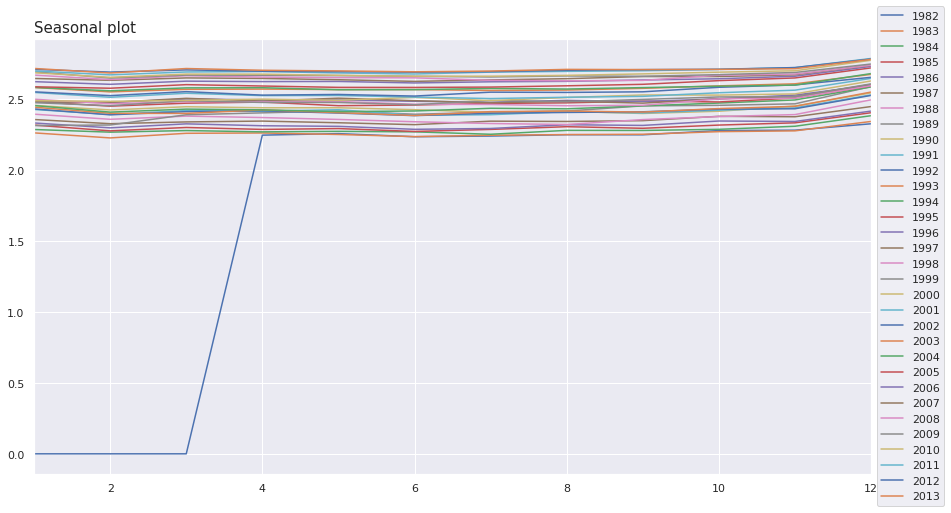

In [29]:
fig, ax = plt.subplots(figsize = (15,8))
dfff.plot(ax = ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Seasonal plot', fontsize = 15, loc='left');

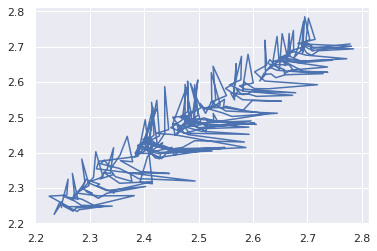

In [30]:
plt.plot(dfn.shift(-2).values, dfn.shift(2).values)

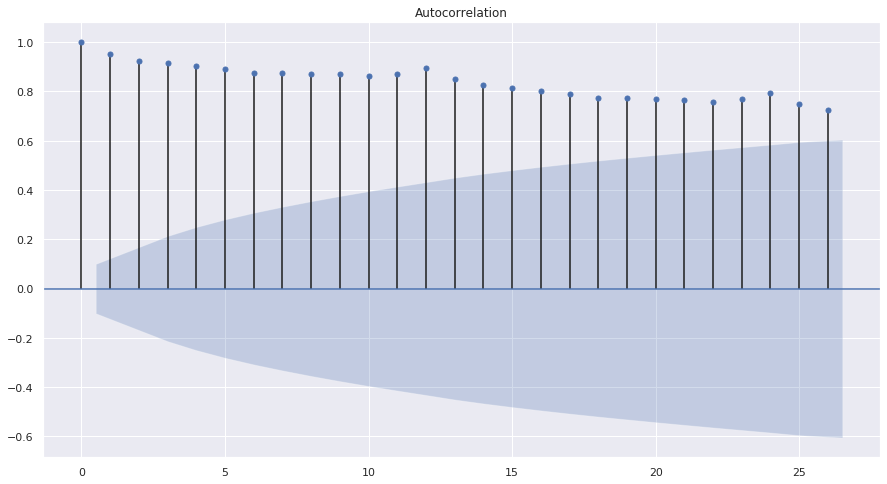

In [31]:
_, ax = plt.subplots(figsize = (15,8))
ax = plot_acf(dfn.values, ax = ax)

In [32]:
acf_val = acf(dfn.values)

/home/isaac/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [33]:
n = df.shape[0]
err = 2/np.sqrt(n)
nlags = len(acf_val)
upper_bound = np.repeat(err, nlags)
lower_bound = np.repeat(-err, nlags)

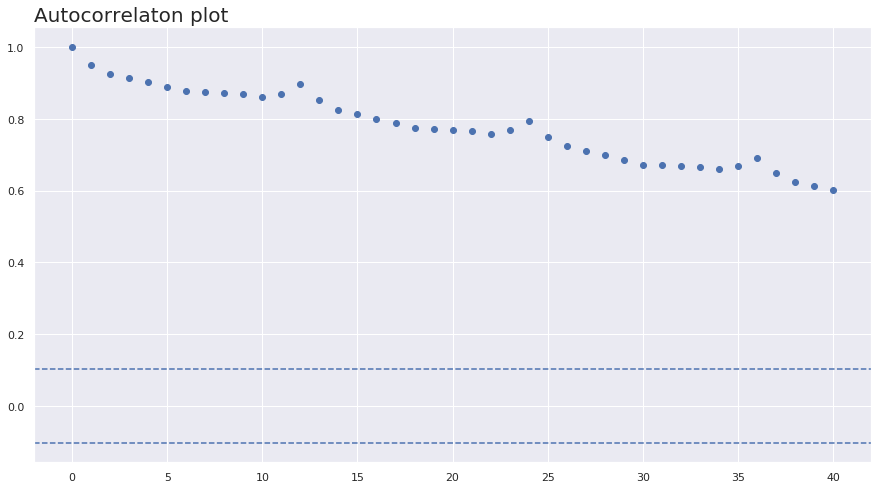

In [34]:
_, ax = plt.subplots(figsize = (15,8))
ax.plot(acf_val, marker = 'o', linestyle = '')
ax.axhline(y = err, linestyle = '--')
ax.axhline(y = -err, linestyle = '--')
plt.title('Autocorrelaton plot', fontsize = 20, loc = 'left');